# 3. LogisticReg(sklearn)

Since the problem we are dealing with is a classification problem where the dependent variable is binary, logistic regression is used over a linear regression

Resources:
- https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
- https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
- https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models

**Import packages**

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

**Set directories**

In [2]:
print(os.getcwd())
dirRawData = "../RawData/"
dirPData = "../PData/"
dirPOutput = "../POutput/"

C:\Users\munch\Documents\Cass MSc\Term 3\Machine Learning\Coursework\PCode


**Load data**

In [3]:
f_name = dirPData + '02_df.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
df_all_onehot = dict_['df_all_onehot']

del f_name, dict_

f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
vars_ind_num = dict_['vars_ind_num']
var_dep = dict_['var_dep']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del f_name, dict_

**Split data into training, validation and test folds**

In [4]:
idx_train  = np.where(df_all_onehot['fold'].isin(np.arange(0,8)))[0] #[0,1,2,3,4,5,6,7]
idx_val    = np.where(df_all_onehot['fold'].isin([8,9]))[0] #[8,9]
idx_design = np.where(df_all_onehot['fold'].isin(np.arange(0,10)))[0] #[0,1,2,3,4,5,6,7,8,9]
idx_test = np.where(df_all_onehot['fold'].isin([10]))[0]

In [5]:
vars_ind = vars_ind_num + vars_ind_onehot

**Prepare X and Y datasets**

In [6]:
#prepare x and y data
x = df_all_onehot[vars_ind].values
y = df_all_onehot[var_dep].values

y_train = y[idx_train]
y_val = y[idx_val]
y_design = y[idx_design]

In [7]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
standardScaler_ = StandardScaler()
standardScaler_.fit(x[idx_train])

X_train = standardScaler_.transform(x[idx_train])
X_val   = standardScaler_.transform(x[idx_val])
X_test = standardScaler_.transform(x[idx_test])
X_design = standardScaler_.transform(x[idx_design])

**L2 Logistic Regression**

In [8]:
lr2_= LogisticRegression(penalty='l2',solver='liblinear')
lr2_.fit(X=X_train, y = np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
# prediction (probabilities)
lr2__pred_train_prob = lr2_.predict_proba(X_train)
lr2__pred_val_prob   = lr2_.predict_proba(X_val)
lr2__pred_test_prob = lr2_.predict_proba(X_test)

#prediction (0 or 1 output)
lr2__pred_train = lr2_.predict(X_train)
lr2__pred_val   = lr2_.predict(X_val)
lr2__pred_test = lr2_.predict(X_test)

In [10]:
#print accuracy of the training and validation
train_score = lr2_.score(X_train,y_train)
val_score = lr2_.score(X_val, y_val)
print("train score is {}".format(train_score))
print("val score is {}".format(val_score))

train score is 0.9287126652096992
val score is 0.9192520186995325


In [12]:
#save output for submission
import csv
f_name = dirPOutput + 'l2logreg.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], lr2__pred_test_prob[:,1]))

This baseline logistic regression with l2 penalty yielded a result of 0.85111 on kaggle

Text(0.5, 1.0, 'Train Accuracy: 0.92726')

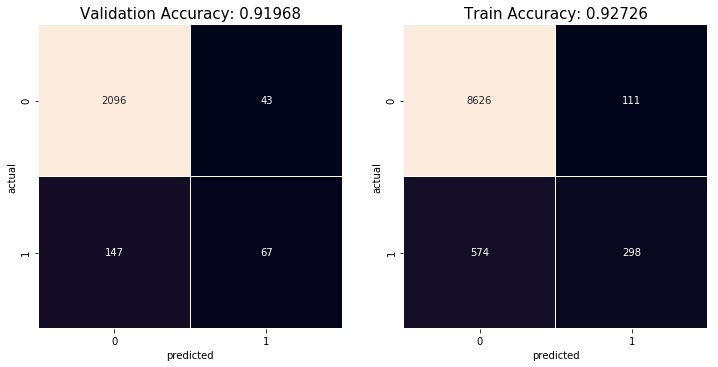

In [38]:
#confusion matrix
from sklearn import metrics
import seaborn as sns

cm_val = metrics.confusion_matrix(y_val,lr2__pred_val)
cm_train = metrics.confusion_matrix(y_train,lr2__pred_train)

plt.figure(figsize = (12,10))

plt.subplot(121)
sns.heatmap(cm_val, annot= True, fmt = "d", linewidths=.5, square = True, cbar = False);
plt.ylabel('actual')
plt.xlabel('predicted')
all_sample_title = 'Validation Accuracy: {0:.5f}'.format(val_score)
plt.title(all_sample_title, size = 15)

plt.subplot(122)
sns.heatmap(cm_train, annot= True, fmt = "d", linewidths=.5, square = True, cbar = False);
plt.ylabel('actual')
plt.xlabel('predicted')
all_sample_title = 'Train Accuracy: {0:.5f}'.format(train_score)
plt.title(all_sample_title, size = 15)

The confusion matrices above shows how accurate the predictions are, the elements in the diagonal are events in which the predicted value = actual value. For example, element(1,1) in the matrix shows the instances that the predicted value of 0 equaled to the actual value of 0; in other words, out of 2139 actual 0s, the model predicted 2096 correctly.

In [24]:
#kfold cross validation for l2 Regression
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)

from sklearn.model_selection import cross_val_score
result_roc_auc = cross_val_score(lr2_, X_design, np.ravel(y_design), cv=kf, scoring='roc_auc')
result_accuracy = cross_val_score(lr2_, X_design, np.ravel(y_design), cv=kf, scoring='accuracy')
print("average score using 10 fold cross validation on design data: {}".format(result_accuracy.mean()))
print("average roc_auc score using 10 fold cross validation on design data: {}".format(result_roc_auc.mean()))

average score using 10 fold cross validation on design data: 0.9179084137322124
average roc_auc score using 10 fold cross validation on design data: 0.8301530696775012


In [25]:
#print roc_auc_score
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(y_train,lr2__pred_train)
auc_val = roc_auc_score(y_val,lr2__pred_val)
print("train auc: {}".format(auc_train))
print("val auc: {}".format(auc_val))

train auc: 0.6645192647949824
val auc: 0.6464906301748131


In [26]:
#fit using design data
lr2_.fit(X=X_design, y = np.ravel(y_design))
lr2__pred_test_prob = lr2_.predict_proba(X_test)
lr2__pred_test = lr2_.predict(X_test)

**L1 Logistic Regression**

In [27]:
#Using lasso regression -> penalty = l1
lr1_= LogisticRegression(penalty = 'l1', solver ='liblinear')
lr1_.fit(X=X_train, y = np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# prediction (probabilities)
lr1__pred_train_prob = lr1_.predict_proba(X_train)
lr1__pred_val_prob   = lr1_.predict_proba(X_val)
lr1__pred_test_prob = lr1_.predict_proba(X_test)

#prediction (0 or 1)
lr1__pred_train = lr1_.predict(X_train)
lr1__pred_val   = lr1_.predict(X_val)
lr1__pred_test = lr1_.predict(X_test)

In [29]:
#print accuracy of the training and validation
train_score = lr1_.score(X_train,y_train)
val_score = lr1_.score(X_val, y_val)
print("train score is {}".format(train_score))
print("val score is {}".format(val_score))

train score is 0.9272556977833282
val score is 0.9196770080747981


In [30]:
#print roc_auc_score
auc_train = roc_auc_score(y_train,lr1__pred_train)
auc_val = roc_auc_score(y_val,lr1__pred_val)
print("train auc: {}".format(auc_train))
print("val auc: {}".format(auc_val))

train auc: 0.6559755752452135
val auc: 0.6467243842655097


In [31]:
from sklearn.model_selection import cross_val_score
result_roc_auc = cross_val_score(lr1_, X_design, np.ravel(y_design), cv=kf, scoring='roc_auc')
result_accuracy = cross_val_score(lr1_, X_design, np.ravel(y_design), cv=kf, scoring='accuracy')
print("average score using 10 fold cross validation on design data: {}".format(result_accuracy.mean()))
print("average roc_auc score using 10 fold cross validation on design data: {}".format(result_roc_auc.mean()))

average score using 10 fold cross validation on design data: 0.9185775894585964
average roc_auc score using 10 fold cross validation on design data: 0.834327713670884


In [32]:
#fit using design data
lr1_.fit(X=X_design, y = np.ravel(y_design))
lr1__pred_test_prob = lr1_.predict_proba(X_test)
lr1__pred_test = lr1_.predict(X_test)

It seems that the l1 regression had higher kfold cross validation scores than l2 regression. Thus we would expect l1 to give a better score on Kaggle. Next we employ grid search to optimize the parameters before submitting again on Kaggle

**Optimize Logistic Regression through grid search**

We use grid search to optimize the parameter lambda,the parameter "C" = 1/lambda in sklearn's logistic regression function, and compare penalty = "l1" or "l2".

In [51]:
from sklearn.model_selection import GridSearchCV

C=[0.05,0.1,1.0,1.5,2.0]
penalty = ["l1","l2"]
param_grid = dict(penalty = penalty,C=C)
lr_= LogisticRegression(solver ='liblinear')
grid = GridSearchCV(estimator=lr_, param_grid=param_grid, cv = 10, n_jobs=-1, scoring = 'roc_auc')
#cv = number of folds for validation

In [52]:
grid_result = grid.fit(X_design, np.ravel(y_design))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # Summarize results

Best: 0.853389 using {'C': 0.05, 'penalty': 'l1'}


The auc score (approx 0.85) is higher than the 10 fold cross validation auc scores (approx 0.83) for both the l1 and l2 regressions (trained on design data). Thus we expect this to yield a higher kaggle score

In [53]:
#use optimized logistic regression to predict test data
lropt_= grid.predict(X_test)
lropt_prob = grid.predict_proba(X_test)

**Save prediction**

In [54]:
import csv
f_name = dirPOutput + 'optimizelogisticreg.csv'

df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w',newline='') as csvfile:
    writer=csv.writer(csvfile,delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], lropt_prob[:,1]))

Using the best parameters for the logistic regression, we managed to improve the kaggle score to 0.86802

In [62]:
#save data
lropt_prob_design = grid.predict_proba(X_design)
dict_ = {'lropt_prob': lropt_prob_design,
        'lropt_prob_test':lropt_prob}

f_name = dirPData + 'logreg.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name